Viscoelastoplasticity in simple shear
======

The viscoelastic rheology outlined previously can be extended to a viscoelastoplastic rheology. This is achieved by parameterising brittle behaviour using a non-linear effective viscosity when stresses exceed a maximum yield strength, discussed in depth by [Moresi et al, 2003](http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1). 

Given that the deformation rate, $D_{ij}$, is the sum of the viscous, elastic and plastic parts, 

$$ D_{ij} = D^v_{ij} + D^e_{ij} + D^p_{ij} = \frac{\tau_{ij}}{2\eta} + \frac{\dot\tau_{ij}}{2\mu} + \lambda\frac{\tau_{ij}}{2|\tau|}$$

where $v$, $e$ and $p$ signify the viscous, elastic and plastic components of strain rate, $\tau$ is stress, $\eta$ shear viscosity, $\mu$ shear modulus, $\lambda$ a parameter to be determined such that the stress remains on the yield surface, and $|\tau| \equiv (\tau_{ij}\tau_{ij}/2)^{1/2}$. The plastic flow rule introduces non-linearity to the constitutive law, and will generally require iteration to find an equilibrium state.

The effective viscosity for yielded material can be found as for the viscoelastic case, by writing $\dot\tau$ as a finite difference, substituting into the strain rate equation and solving for $\tau$. Resulting is a stress history term given by,

$$\tau^t = \eta_{eff}\Big(2D^t + \frac{1}{\mu\Delta t_e}\tau^{t-1}\Big)$$

with an effective viscosity, $\eta_{eff}$, at yielding, $|\tau| = \tau_{yield}$, of

$$ \eta_{eff} = \frac{\eta\tau_y\Delta t_e\mu}{\eta\tau_y+\tau_y\Delta t_e\mu+\lambda\eta\Delta t_e\mu}$$

Alternatively, the effective viscosity for yielded material can be found directly using 

$$\eta_{eff} = \tau_{yield} / |D_{eff}|$$

with $|D| = (D_{ij}D_{ij}/2)^{1/2}$ and 

$$D_{eff} = 2D^t + \frac{1}{\mu\Delta t_e}\tau^{t-1}$$



The iteration of $\eta$ is repeated until the velocity solution is unchanged to within an error tolerance required for the solution as a whole.

**Simple shear in two dimensions**

This notebook models a viscoelastoplastic material, with a maximum yield strength of $\tau_y = 2.0$, undergoing simple shear in two dimensions. The vertical velocity boundary conditions are periodic, the bottom velocity bc is no-slip with a horizontal shear velocity bc applied to the top wall until $t = 1$.  For $t > 1$ the top wall velocity is taken to zero with the stored elastic stress allowed to relax.

Material layout | Solution
- | -
![title](input/050 material layout.png) | ![title](input/050 solution.png)

**References**

Moresi, L., Dufour, F., & Mühlhaus, H. B. (2003). A Lagrangian integration point finite element method for large deformation modeling of viscoelastic geomaterials. Journal of Computational Physics, 184(2), 476-497. http://www.sciencedirect.com/science/journal/00219991/184/2?sdc=1

In [2]:
import underworld as uw
from underworld import function as fn
import glucifer
uw.matplotlib_inline()

import matplotlib.pyplot as pyplot
pyplot.ion()  # don't hang on show() for pure python runs
import numpy as np
import math

import mpi4py
comm = mpi4py.MPI.COMM_WORLD
import os

In [3]:
# create output directory
try:
    workdir
except NameError:
    workdir = os.path.abspath(".")

outputPath = os.path.join(workdir,"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

In [4]:
#Create mesh and finite element variables
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (16, 16), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.),
                                 periodic    = [True, False]  ) 

velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
#Apply conditions on the boundaries
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

shearVelocity = 0.05

for index in mesh.specialSets["MinJ_VertexSet"]:
    velocityField.data[index] = [0., 0.]
for index in mesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index] = [shearVelocity, 0.]
    
periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( jWalls, jWalls) ) 

In [6]:
#Setup a swarm
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout   = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

In [7]:
# Add swarm variable
materialIndex  = swarm.add_variable( dataType="int",    count=1 )

viscoelastic = 0
viscoelastic_bar  = 1

xCoordFn = fn.input()[0]
conditions = [ ( ( xCoordFn > 0.4 ) & (xCoordFn < 0.6 ) , viscoelastic_bar),
               (  True                                  , viscoelastic )]

materialIndex.data[:]  = fn.branching.conditional( conditions ).evaluate(swarm)

# initialise swarm variables for viscoelastic rheology & analysis
previousStress         = swarm.add_variable( dataType="double", count=3 )
previousStress.data[:] = [0., 0., 0.]



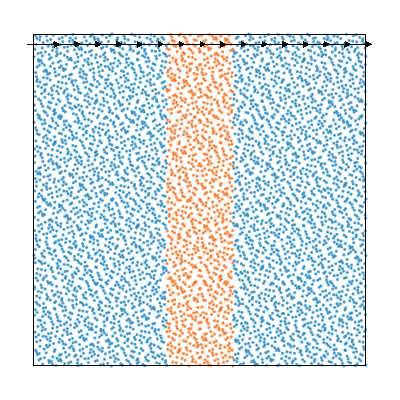

In [8]:
figsize=(400,400) 
figMaterial = glucifer.Figure( figsize=figsize )
figMaterial.append( glucifer.objects.Points(swarm, materialIndex, pointSize=4.0, colourBar=False) )
figMaterial.append( glucifer.objects.VectorArrows(mesh, velocityField) )
figMaterial.show()

In [9]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)
strainRate_2ndInvariant_2 = fn.math.sqrt(0.5*(strainRate[0]**2+strainRate[1]**2)+strainRate[2]**2)

In [10]:
## Define material parameters, observation time and yield stress
eta     = 1.0e2  # viscosity
mu      = 1.0e2  # elastic modulus

alpha   = eta / mu                         # viscoelastic relaxation time
dt_e    = 0.1                              # elastic time step

# viscoelastic effective viscosity
eta_eff = ( eta * dt_e ) / (alpha + dt_e)  # effective viscosity

# yield stress
yieldStressFn = fn.misc.constant(2.)

In [11]:
# define viscoelastic effective strain rate
D_eff    = strainRate+0.5*previousStress/(mu*dt_e)
D_effInv = fn.math.sqrt(0.5*(D_eff[0]**2+D_eff[1]**2)+D_eff[2]**2)

# define viscosity at yield stress
min_viscosity = 0.001
yieldingViscosityFn = 0.5 * yieldStressFn / ( D_effInv + 1.0e-18 )  

# define viscosity function
viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, eta_eff), 
                                                   min_viscosity))


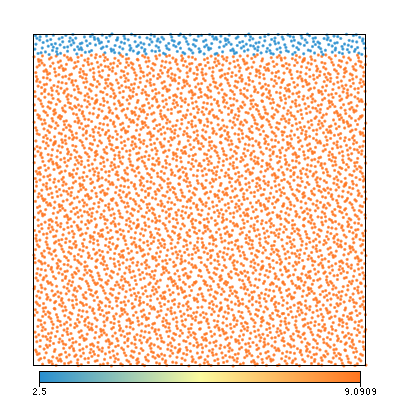

In [12]:
# plot viscosity 
figViscosity = glucifer.Figure( figsize=figsize )
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=4.0) )
figViscosity.show()

In [13]:
# define the viscoelastic stress tensor
viscousStressFn = 2. * viscosityFn * strainRate 
#elasticStressFn = eta_eff / ( mu * dt_e ) * previousStress
elasticStressFn = viscosityFn / ( mu * dt_e ) * previousStress
stressFn        = viscousStressFn + elasticStressFn

viscousStress_2nInvariant = fn.math.sqrt(0.5*(viscousStressFn[0]**2+viscousStressFn[1]**2)+viscousStressFn[2]**2)
elasticStress_2nInvariant = fn.math.sqrt(0.5*(elasticStressFn[0]**2+elasticStressFn[1]**2)+elasticStressFn[2]**2)
stress_2ndInvariant = fn.math.sqrt(0.5*(stressFn[0]**2+stressFn[1]**2)+stressFn[2]**2)


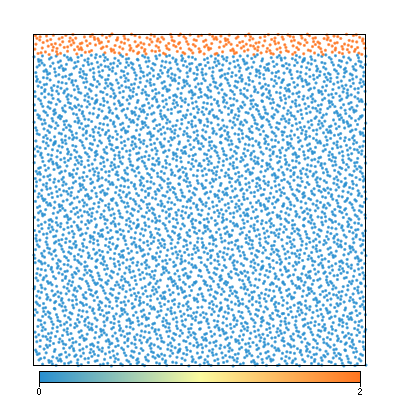

In [14]:
# plot 2nd invariant of stress
figStressInv = glucifer.Figure( figsize=figsize )
figStressInv.append( glucifer.objects.Points(swarm, stress_2ndInvariant, pointSize=4.0) )
figStressInv.show()

In [15]:
# density
densityMapFn = fn.misc.constant( 1.0 )

# buoyancy force term
z_hat   = ( 0.0, 1.0 )
buoyancyFn = -densityMapFn * z_hat

In [16]:
# create stokes system, solver and advector
stokes = uw.systems.Stokes( velocityField       = velocityField, 
                               pressureField    = pressureField,
                               voronoi_swarm    = swarm, 
                               conditions       = [periodicBC,],
                               fn_viscosity     = viscosityFn, 
                               fn_bodyforce     = buoyancyFn,
                               fn_stresshistory = elasticStressFn)

solver   = uw.systems.Solver( stokes )
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

In [17]:
# define an update function
def update():
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    # cap time step for observation time 
    if dt > ( dt_e / 5. ):
        dt = dt_e / 5.   # dt_e/10 for time to coincide with maxShearTime

    # Advect using this timestep size.
    advector.integrate(dt)
        
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    stressFn_data = stressFn.evaluate(swarm)
    previousStress.data[:] = ( phi*stressFn_data[:] + ( 1.-phi )*previousStress.data[:] )
    
    return time+dt, step+1

In [18]:
# Stepping. Initialise time and timestep.
time = 0.
step = 0

# set time to shear
maxShearTime = 1.    # max time for shearing velocity BC
maxTime      = 8.

# save stress history for plotting
tTracer           = []
previousStress_xy = []
totalStress_xy    = []
invStress         = []

In [19]:
# main time stepping loop
while time < maxTime :
    # output for analysis               
    tTracer.append(time)
    # keep record of the zeroth particle's shear stress...
    if comm.rank == 0:
        previousStress_xy.append(previousStress[2].evaluate(swarm)[0])
        totalStress_xy.append(stressFn[2].evaluate(swarm)[0])
        invStress.append(stress_2ndInvariant.evaluate(swarm)[0])

    # solve stokes problem
    solver.solve(nonLinearIterate=True)

    # save model data
    if( comm.rank ==0):
        with open(outputPath+'/VepShear2D-FrequentOutput.dat','ab') as f:
            np.savetxt(f, np.column_stack((step, time, previousStress_xy[step])), fmt='%.8e')

        if step%10 == 0:
            print time, step, stress_2ndInvariant.evaluate(swarm).max()
    
    # We are finished with current timestep, update.
    time, step = update()
    
    # change BC if time > 1.0, then watch stress decay
    if time >= maxShearTime:
        for index in mesh.specialSets["MaxJ_VertexSet"]:
            velocityField.data[index] = [0., 0.]

0.0 0 0.4545909851361829
0.2 10 1.2166138274629756
0.4 20 1.8508769545050856
0.6 30 2.0000000000000004
0.8 40 2.0000000000000004
1.0 50 1.8176097614846585
1.2 60 1.5129108559766578
1.4 70 1.2593077270879875
1.6 80 1.0482163039860366
1.8 90 0.8725119887886684
2.0 100 0.726262323643636
2.2 110 0.6045295878229853
2.4 120 0.5032039127819251
2.6 130 0.418864346349238
2.8 140 0.3486633949129033
3.0 150 0.2902308872080331
3.2 160 0.24159398150894043
3.4 170 0.20111047713288716
3.6 180 0.16741359164241137
3.8 190 0.13936736541984351
4.0 200 0.1160227375549624
4.2 210 0.09659148734632447
4.4 220 0.08041758879803487
4.6 230 0.06695501289024514
4.8 240 0.055749209838696995
5.0 250 0.04642186101137879
5.2 260 0.03865827692687229
5.4 270 0.03219619111776461
5.6 280 0.02681735617874513
5.8 290 0.022341158845188877
6.0 300 0.01861453730164023
6.2 310 0.015512574313048564
6.4 320 0.012930524315725812
6.6 330 0.010781332488294418
6.8 340 0.008992417202844416
7.0 350 0.007503422406444517
7.2 360 0.00626

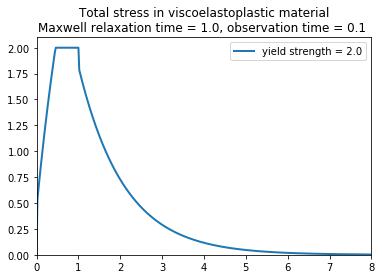

In [24]:
# plot total stress with time
if comm.rank == 0:
    pyplot.plot(tTracer, totalStress_xy, label='yield strength = 2.0', linewidth=2)
    pyplot.legend(loc='best')
    pyplot.axis([0, 8, 0, 2.1])
    pyplot.title('Total stress in viscoelastoplastic material\nMaxwell relaxation time = 1.0, observation time = 0.1 ')

    pyplot.show()